## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from fastai.vision import *
import pandas as pd

## Getting and converting the data

In [11]:
path = Path("/home/michael/Code/video/output/")

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [136]:
fname = 'frame343.jpg'
coordfile = path/'coords.csv'
coords = pd.read_csv(coordfile, dtype = float)
coords.head()

,frame,width,height
0,0.0,252.0,107.0
1,1.0,252.0,107.0
2,2.0,249.0,104.0
3,3.0,246.0,101.0
4,4.0,243.0,98.0


In [13]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'
img2txt_name(fname)

PosixPath('/home/michael/Code/video/output/frampose.txt')

In [164]:
def img2coord(f): 
    f=f.name
    frame = int(f[5:-4])
    return coords.values[frame,1:3]
    #return coords.values[frame,1:3]
    
ctr = img2coord(path/fname)
ctr


array([586., 779.])

In [47]:
coords.values[3,1:3]
int(fname[5:-4])

array([246, 101])

In [115]:
f = (path/fname).name
frame = (f[5:-4])
d= int(frame[-1])

lal = int(f[5:-4][-1])
print(lal)
print(f)
print(frame)

3
frame343.jpg
343


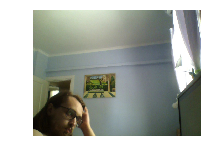

In [139]:
img = open_image(path/fname)
img.show()

In [ ]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [141]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [51]:
get_ctr(fname)

OSError: /home/michael/Code/video/output/frapose.txt not found.

In [156]:
dt = img2coord(path/fname).double()
dt

tensor([586., 779.], dtype=torch.float64)

In [157]:
#ctr = get_ctr(fname)
img.show(y=get_ip(img,dt), figsize=(6, 6))

RuntimeError: expected type torch.DoubleTensor but got torch.FloatTensor

## Creating a dataset

In [169]:
data = (ImageList.from_folder(path)
        .split_by_valid_func(lambda o: int(o.name[5:-4][-1])==3)
        .label_from_func(img2coord, label_cls= FloatList)        
        .databunch()
       )

#.transform(get_transforms(), tfm_y=True, size=(120,160))   .normalize(imagenet_stats)

In [170]:
data

ImageDataBunch;

Train: LabelList (471 items)
x: ImageList
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
y: FloatList
[985. 462.],[472. 599.],[720. 566.],[110.  23.],[1001.  445.]
Path: /home/michael/Code/video/output;

Valid: LabelList (52 items)
x: ImageList
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
y: FloatList
[1642.  439.],[1718.  575.],[169. 564.],[1721.  711.],[ 36. 228.]
Path: /home/michael/Code/video/output;

Test: None

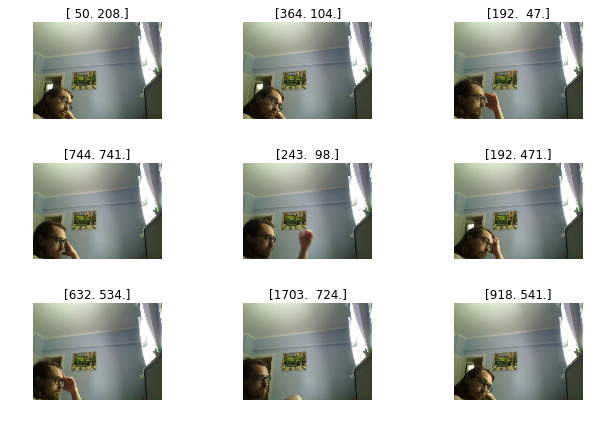

In [171]:
data.show_batch(3, figsize=(9,6))

## Train model

In [172]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/michael/.torch/models/resnet34-333f7ec4.pth
87306240it [00:24, 3495513.08it/s]


In [173]:
learn.lr_find()
learn.recorder.plot()

Traceback (most recent call last):
  File "/home/michael/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/michael/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/michael/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/michael/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/michael/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/michael/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/michael/anaconda3/lib/

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.052076,0.003733
2,0.018467,0.002182
3,0.009045,0.011063
4,0.005409,0.002293
5,0.004046,0.002766


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

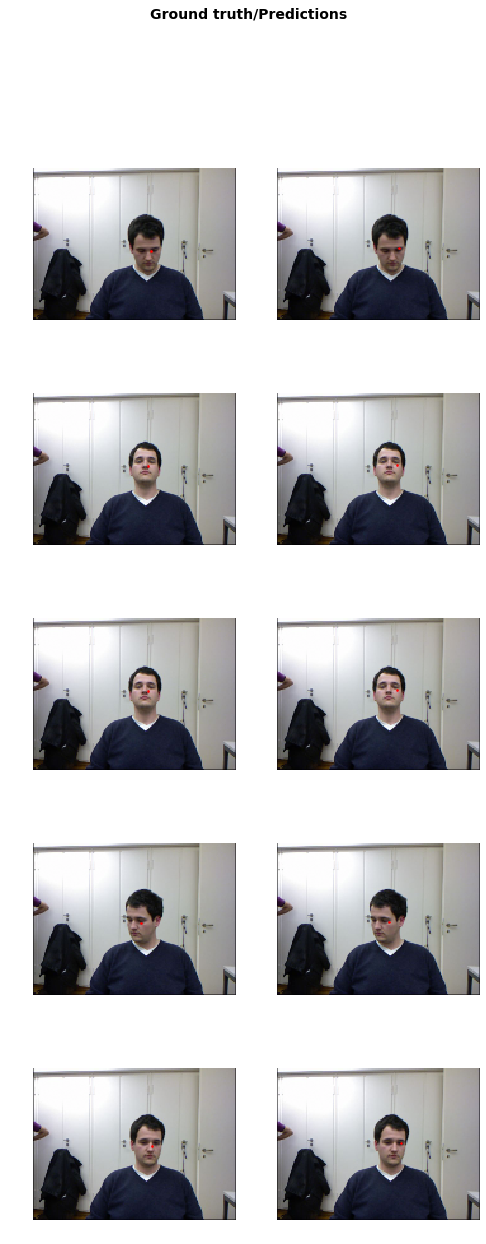

In [ ]:
learn.show_results()

## Data augmentation

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

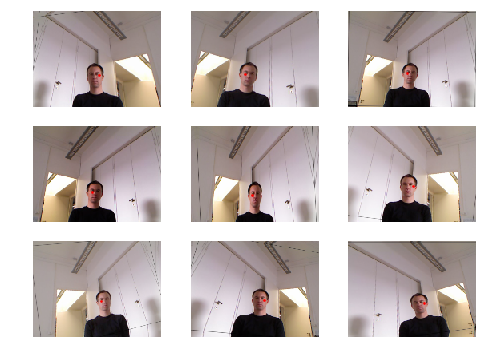

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))